## Executive Summary

**Project Goal:**
I began this project to practice K-Means Clustering with Unsupervised Learning. For the project, I used the mall customer segmentation dataset. The goal was to identify and understand different customer segments based on shoppers' income and spending habits.

**Methodology:**
Though standard libraries like scikit-learn exist, this project manually implements the K-Means Clustering algorithm. This demonstrates the math behind the algorithm, including centroid initialization, distance calculation, and iterative optimization.

**Results:**
The model successfully identified 5 distinct customer groups, providing insights into target groups for marketing strategies.

### Step 0: Import Dependencies and Data

In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [4]:
df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")

### Step 1: Data Exploration

In [5]:
# Verify the data imported correctly

print(df.head(10))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72


In [6]:
# Get an overview of the data. Check for missing values.

df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
# All numeric data is present. Let's verify gender.

df["Gender"].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

*At this stage, we can confirm that there are no missing values. This is a complete dataset. No need to use .fillna as there will be no NaN values.*

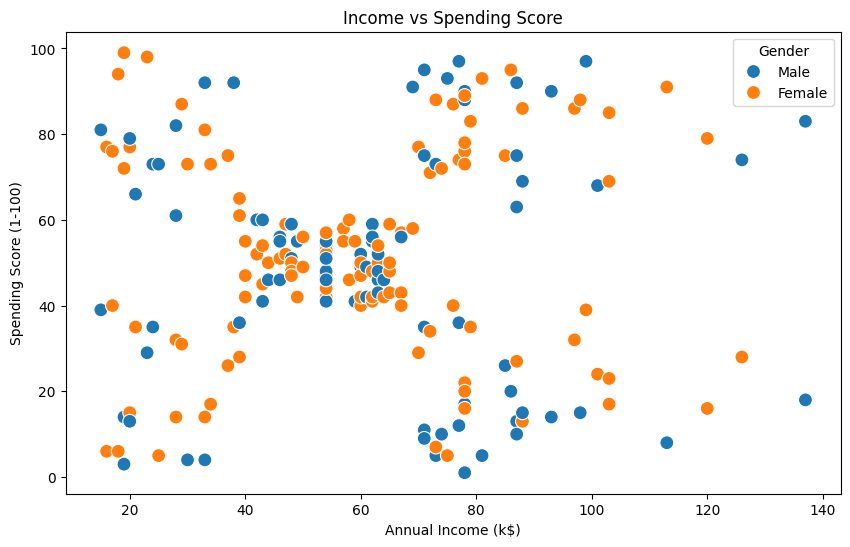

In [14]:
# Take a visual look at the data.


plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Gender', s=100)
plt.title('Income vs Spending Score')
plt.show()

*While drafting this project, I explored other graphs with other features. I included the age, compared it against the spending score and annual income. There were no apparent trends from using that data. The above shows obvious clusters. You can also see in the graph that gender is evenly distributed in each cluster. That does not appear to affect the cluster trends.*

### Step 2: Data Preprocessing

Now, I must prepare the data for numpy. I will remove irrelevant data and convert to numpy

In [16]:
# Create X_train, Remove Customer ID
X_train = df.iloc[:, 1:]

# Drop Age and Gender
X_train = X_train.drop(["Age", "Gender"], axis=1)

#Review
X_train.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [ ]:
# Just taking a peak to confirm success
# Not necessary to run this cell

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=X_train, s=100)
plt.title('Income vs Spending Score')
plt.show()

In [18]:
# Final step in pre-processing - convert to numpy

X = X_train.to_numpy()

In [25]:
# Review

print(X.shape)
print(type(X), "\n")
print(X[:10, :])

(200, 2)
<class 'numpy.ndarray'> 

[[15 39]
 [15 81]
 [16  6]
 [16 77]
 [17 40]
 [17 76]
 [18  6]
 [18 94]
 [19  3]
 [19 72]]


### Step 3: Let the Clustering Begin!

We will now create the formulas to run k-means.

Acknowledgement: The K-Means implementation below is adapted from the assignments in Andrew Ng's Machine Learning Specialization.

#### 3a: Find Closest Centroid for each example

In [26]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): (K, n) centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """
    # Set K
    K = centroids.shape[0]

    idx = np.zeros(X.shape[0], dtype=int)
    
    for i in range(X.shape[0]):

        distance = [] 
        for j in range(centroids.shape[0]):

            # Calculate the norm between (X[i] - centroids[j])
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)
        
        # Calculate index of minimum value in distance
        idx[i] = np.argmin(distance)        
    
    return idx

#### 3b. Find New Centroid Coordinates

In [41]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """

    m, n = X.shape
    
    centroids = np.zeros((K, n))
    
    for k in range(K):

        # count all data points at centroid k
        ck_count = np.sum(idx == k)

        # sum points at centroid k
        ck = np.sum(X[idx == k], axis = 0)

        # prevent dividing by 0 if no data points are in current centroid cluster
        if ck_count > 0:

            # compute the mean of points
            centroids[k] = (1 / ck_count) * ck
    
    return centroids

In [28]:
# The following are all plotting functions to view the clusters and k-Means centroids.
# Currently disabled as I added the multiple_runs_kMeans function.
# These were used when plotting in the single run_kMeans function.
# I will create a separate graph at the bottom for the final results.

"""from matplotlib.colors import ListedColormap

def draw_line(p1, p2, style="-k", linewidth=1):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], style, linewidth=linewidth)

def plot_data_points(X, idx):
    # Define colormap to match Figure 1 in the notebook
    cmap = ListedColormap(["red", "green", "blue", "orange", "purple"])
    c = cmap(idx)
    
    # plots data points in X, coloring them so that those with the same
    # index assignments in idx have the same color
    # plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors=c, linewidth=0.1, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors=c, linewidth=1.5, alpha=0.7)

def plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i):
    
    # Plot the examples
    plot_data_points(X, idx)
    
    # Plot the centroids as black x's
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='k', linewidths=3)
    
    # Plot history of the centroids with lines
    for j in range(centroids.shape[0]):
        draw_line(centroids[j, :], previous_centroids[j, :])
    
    plt.title(f"Iteration number {i}")"""

#### 3c. K-Means Algorithm
This runs K-Means one time. I originally used this as the main function but I encountered local optima several tims so I created an additional function below that runs it multiple times.

In [36]:
def run_kMeans(X, initial_centroids, max_iters=10, type_progress=False, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    # plt.figure(figsize=(8, 6)) # Removed once I added multiple K-Means.

    # Run K-Means
    for i in range(max_iters):

        if type_progress:
            #Output progress
            print(f"K-Means iteration {i}/{max_iters-1}")
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    # plt.show() # Removed once I added multiple K-Means.
    return centroids, idx

#### 3d. Initialize Centroids

In [30]:
# Random Initialization

def kMeans_init_centroids(X, K):
    """
    This function initializes K centroids that are to be 
    used in K-Means on the dataset X
    
    Args:
        X (ndarray): Data points 
        K (int):     number of centroids/clusters
    
    Returns:
        centroids (ndarray): Initialized centroids
    """
    
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    
    return centroids

#### 3e. K-Means multiple runs
This algorithm runs K-Means multiple times to optimize the centroids. It calculates the cost of each centroid during each run and returns the best centroids that produce the lowest cost.

In [39]:
# Runs Multiple K-Means to avoid local optimum.

def multiple_runs_kMeans(X, K, num_runs=10, max_iters=10):
    """
    Runs K-Means multiple times and returns the best centroids and idx 
    based on the lowest cost (distortion).
    """

    min_cost = float("inf")    # Set initial cost to infinity so any cost will be less
    best_centroids = None
    best_idx = None

    for i in range(num_runs):
        # 1. Run K-Means for this iteration
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # 2. Calculate the cost (Distortion) for this run
        current_cost = 0
        
        for k in range(K):
            # Get all data points assigned to cluster k
            points = X[idx == k]
            
            # Calculate the squared difference between these points and the centroid k
            squared_diffs = np.linalg.norm(points - centroids[k]) ** 2 
            
            # Add to current_cost
            current_cost += squared_diffs

        print(f"Cost for iteration # {i + 1}: {current_cost:.2f}")
        
        # 3. Compare and keep the best run
        if current_cost < min_cost:
            min_cost = current_cost
            best_centroids = centroids
            best_idx = idx

    print(f"Best cost found: {min_cost:.2f}")
    return best_centroids, best_idx

In [45]:
# Initializing with 5 clusters. Obvious from original graph.

best_centroids, best_idx = multiple_runs_kMeans(X, K = 5, num_runs = 20)

Cost for iteration # 1: 66674.36
Cost for iteration # 2: 75036.49
Cost for iteration # 3: 44454.48
Cost for iteration # 4: 44454.48
Cost for iteration # 5: 75611.70
Cost for iteration # 6: 51253.90
Cost for iteration # 7: 44448.46
Cost for iteration # 8: 44448.46
Cost for iteration # 9: 66532.58
Cost for iteration # 10: 66497.20
Cost for iteration # 11: 67553.83
Cost for iteration # 12: 44804.68
Cost for iteration # 13: 75611.70
Cost for iteration # 14: 66532.58
Cost for iteration # 15: 44448.46
Cost for iteration # 16: 44448.46
Cost for iteration # 17: 44448.46
Cost for iteration # 18: 44454.48
Cost for iteration # 19: 44448.46
Cost for iteration # 20: 44454.48
Best cost found: 44448.46


In [43]:
print(best_centroids)

[[26.30434783 20.91304348]
 [88.2        17.11428571]
 [25.72727273 79.36363636]
 [55.2962963  49.51851852]
 [86.53846154 82.12820513]]


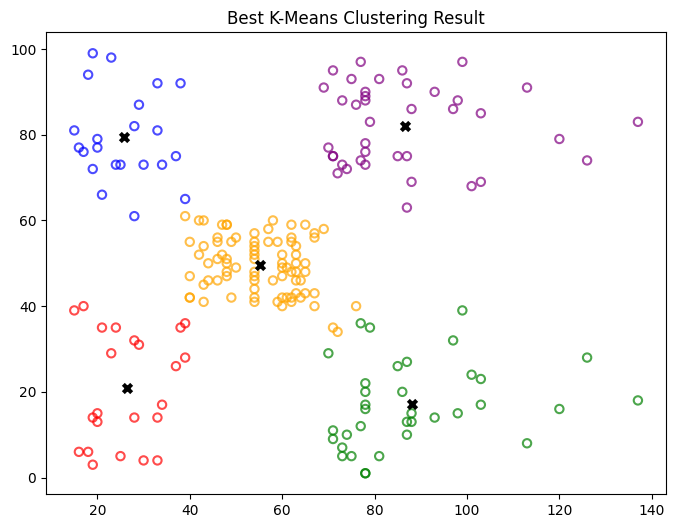

In [44]:
# Plot the best clustering found
plt.figure(figsize=(8, 6))

# 1. Plot the data points colored by their cluster
# This uses the helper function provided in the notebook
plot_data_points(X, best_idx)

# 2. Plot the final centroids as black 'X's
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], c='k', marker='x', linewidths=3)

# 3. Add title
plt.title('Best K-Means Clustering Result')
plt.show()

In [52]:
# 1. Add the cluster labels to your original DataFrame
df['Cluster'] = best_idx.astype(int) + 1

# 2. Calculate the mean Age, Income, and Score for each cluster
cluster_stats = df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

# 3. Also get the count of customers in each cluster so you know how big each group is
cluster_counts = df['Cluster'].value_counts().sort_index()

# Combine them for a clean view
analysis = cluster_stats.assign(Count=cluster_counts)
print(analysis)

               Age  Annual Income (k$)  Spending Score (1-100)  Count
Cluster                                                              
1        32.692308           86.538462               82.128205     39
2        25.272727           25.727273               79.363636     22
3        45.217391           26.304348               20.913043     23
4        42.716049           55.296296               49.518519     81
5        41.114286           88.200000               17.114286     35


### Step 4: Cluster Analysis and Profiling

This dataset points to 5 obvious clusters:

**1. VIPs** *(High Income, High Spend)*
* These people earn a lot and want to spend it. They are the ideal shoppers for the mall to focus its attention on.

**2. Impulse** *(Low Income, High Spend)*
* This is a dangerous group to focus on, especially if they finance their purchases. It does not say it explicitly in the data but I imagine this group would be more likely to default on any store or credit cards, or buy now pay later plans. 

**3. Sensible** *(Low Income, Low Spend)*
* These people do not earn a lot but they live within their means. They are likely bargains and can be swayed by a good deal.

**4. Average** *(Mid Income, Mid Spend)*
* This is your average shopper, the highest count in any cluster. They make a moderate amount and spend modestly. This would be another great group to focus on. 

**5. Savers** *(High Income, Low Spend)*
*  These people earn a lot but they are thrifty and do not want to spend it. This could be a good group to focus on. It's likely there are certain items they are willing to buy.

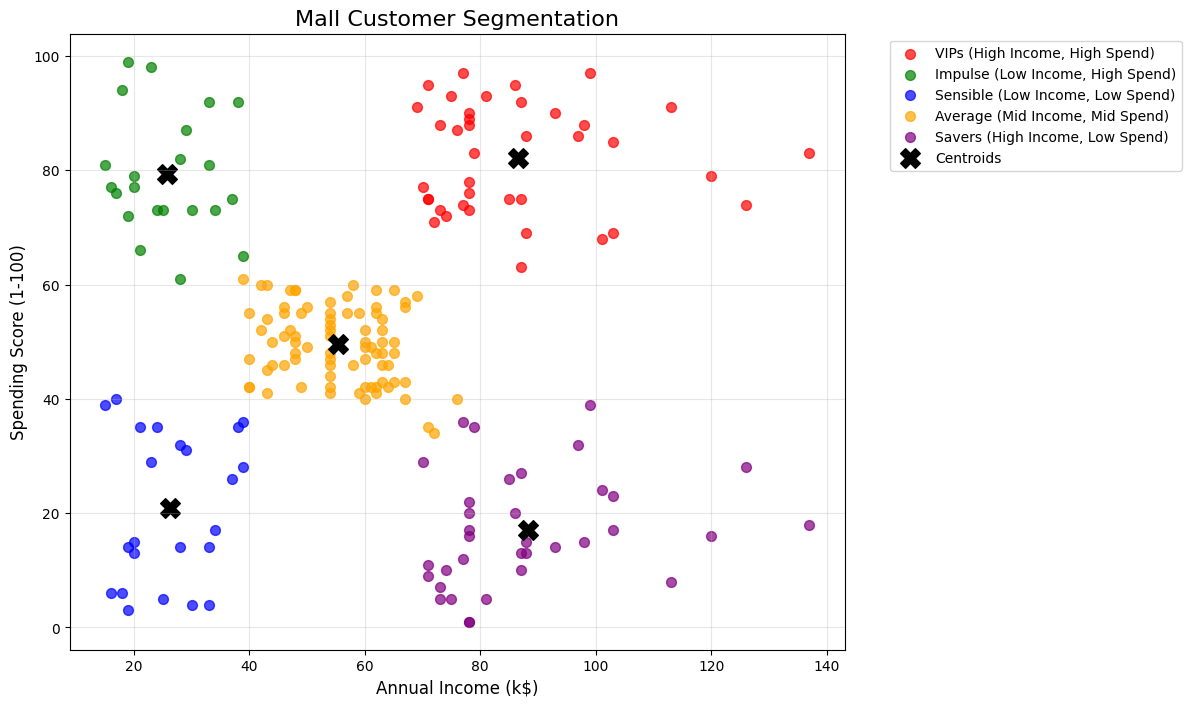

In [53]:
import matplotlib.pyplot as plt

# 1. Define your labels based on your analysis
cluster_labels = {
    0: "VIPs (High Income, High Spend)",
    1: "Impulse (Low Income, High Spend)",
    2: "Sensible (Low Income, Low Spend)",
    3: "Average (Mid Income, Mid Spend)",
    4: "Savers (High Income, Low Spend)"
}

# 2. Define colors to match your previous graph
colors = ["red", "green", "blue", "orange", "purple"]

plt.figure(figsize=(10, 8))

# 3. Loop through each cluster to plot it with its specific label
for i in range(5):
    # Select only the data points that belong to cluster 'i'
    points = X[best_idx == i]
    
    # Plot them
    plt.scatter(points[:, 0], points[:, 1], s=50, c=colors[i], label=cluster_labels[i], alpha=0.7)

# 4. Plot the centroids (the black X marks)
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

# 5. Add titles and a legend
plt.title('Mall Customer Segmentation', fontsize=16)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside to keep graph clean
plt.grid(True, alpha=0.3)
plt.show()